# ✅ PHASE 1 (RESTARTED): Load and Display One Image-Mask Pair #

## Manually Check All _sat.png Files ##

In [1]:
import os
from glob import glob

train_folder = r"D:\Internship Project\train"

# Try all image extensions
extensions = ['png', 'jpg', 'jpeg']
sat_imgs = []

for ext in extensions:
    sat_imgs.extend(glob(os.path.join(train_folder, f"*sat.{ext}")))

print("Total satellite images found:", len(sat_imgs))
print("Example file:", sat_imgs[0] if sat_imgs else "No images found!")


Total satellite images found: 803
Example file: D:\Internship Project\train\100694_sat.jpg


## Load and Display One Image-Mask Pair ##

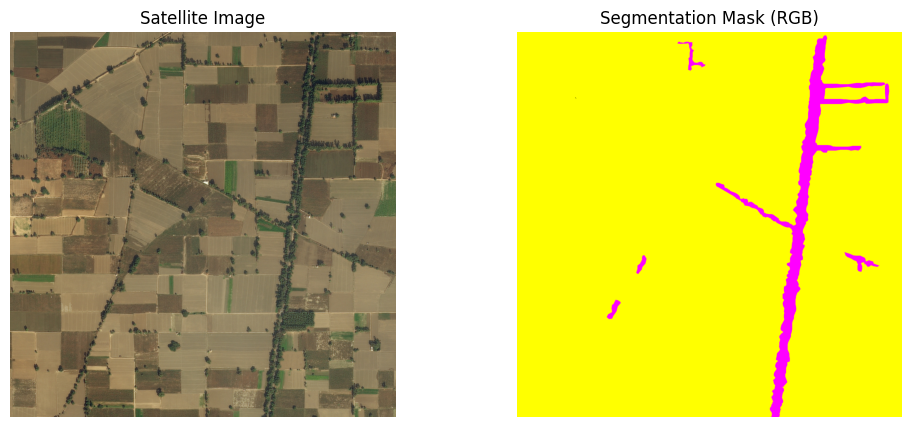

In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Paths
image_path = r"D:\Internship Project\train\100694_sat.jpg"
mask_path = r"D:\Internship Project\train\100694_mask.png"
class_dict_path = r"D:\Internship Project\class_dict.csv"

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load mask
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Load class colors from class_dict.csv
class_df = pd.read_csv(class_dict_path)
colors = class_df[['r', 'g', 'b']].values.astype(np.uint8)

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Satellite Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Segmentation Mask (RGB)")
plt.axis('off')
plt.show()


# ✅ PHASE 2: Build a TensorFlow Dataset Loader #

## RGB Mask → Class Index Conversion Function ##

In [3]:
def load_class_dict(csv_path):
    df = pd.read_csv(csv_path)
    color_to_index = {}
    for i, row in df.iterrows():
        color = tuple([row['r'], row['g'], row['b']])
        color_to_index[color] = i
    return color_to_index

def rgb_to_class(mask, color_map):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for color, class_idx in color_map.items():
        matches = np.all(mask == color, axis=-1)
        class_mask[matches] = class_idx
    return class_mask


## Dataset Loader Using tf.data ##

In [4]:
import tensorflow as tf
import os
from glob import glob

# Update these
train_folder = r"D:\Internship Project\train"
class_dict_path = r"D:\Internship Project\class_dict.csv"
IMG_SIZE = 256
BATCH_SIZE = 8

# Load color → class index
color_map = load_class_dict(class_dict_path)

# Get image paths
image_paths = sorted(glob(os.path.join(train_folder, "*_sat.jpg")))
mask_paths = [p.replace('_sat.jpg', '_mask.png') for p in image_paths]

# Wrapper function for tf.data
def parse_function(image_path, mask_path):
    image_path = image_path.numpy().decode()
    mask_path = mask_path.numpy().decode()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = rgb_to_class(mask, color_map)

    return image.astype(np.float32), mask.astype(np.uint8)

# TensorFlow wrapper
def tf_parse(image_path, mask_path):
    image, mask = tf.py_function(parse_function, [image_path, mask_path], [tf.float32, tf.uint8])
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE])
    return image, mask

# Create tf.data.Dataset
def create_dataset(image_paths, mask_paths):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    ds = ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(image_paths, mask_paths)


## Visualize a Batch ##

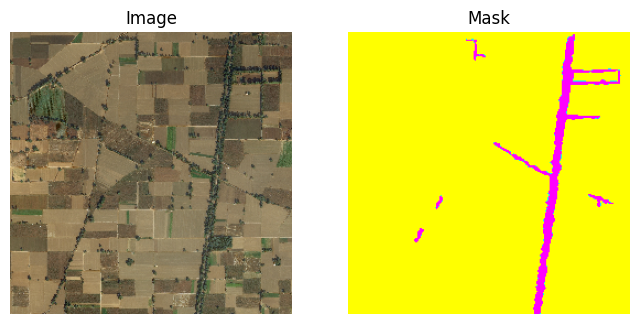

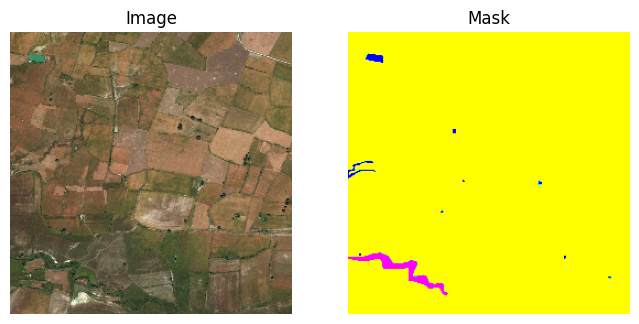

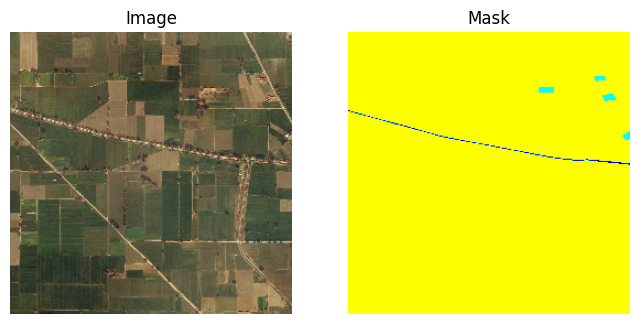

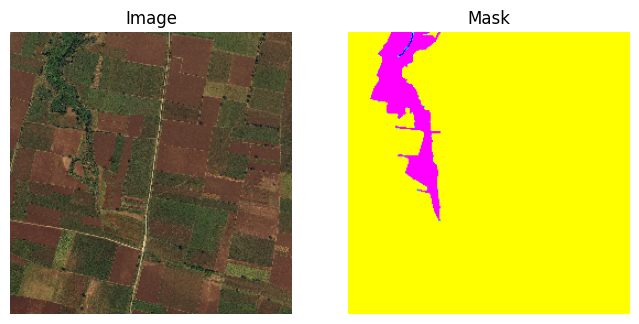

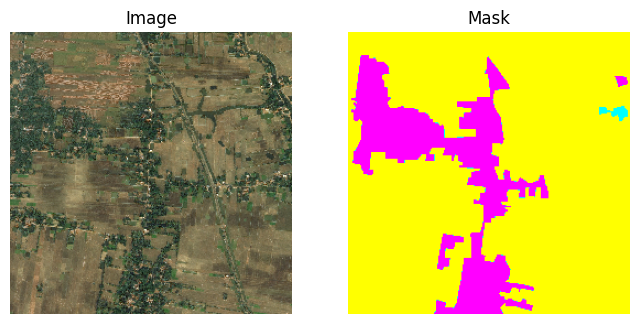

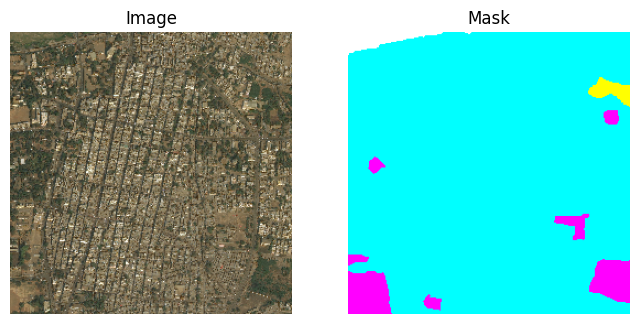

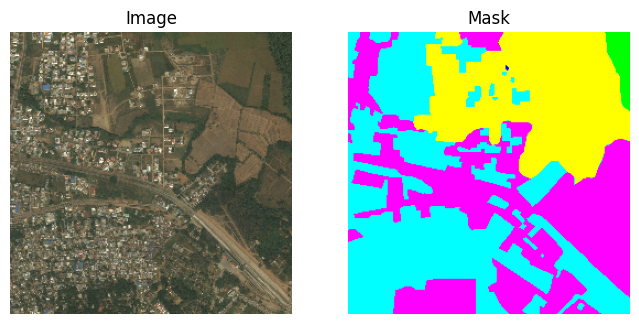

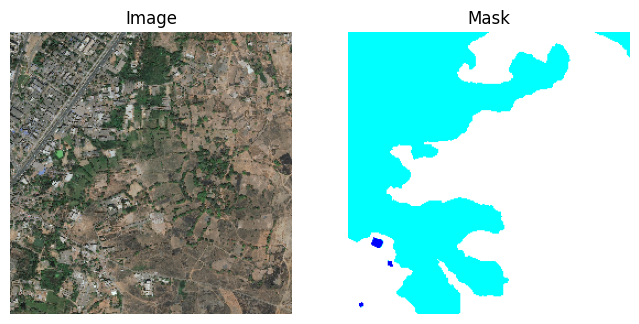

In [5]:
# Load colormap for visualization
colormap = np.array([[row['r'], row['g'], row['b']] for _, row in pd.read_csv(class_dict_path).iterrows()], dtype=np.uint8)

# Decode class-index mask to RGB
def decode_mask(mask, colormap):
    return colormap[mask]

# Visualize batch
for imgs, masks in train_ds.take(1):
    for i in range(imgs.shape[0]):
        img = imgs[i].numpy()
        mask = masks[i].numpy()
        mask_rgb = decode_mask(mask, colormap)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_rgb)
        plt.title("Mask")
        plt.axis('off')
        plt.show()


# ✅ PHASE 3: Build a U-Net Model in TensorFlow (Industry Standard) #

## Define the U-Net Architecture ##

In [12]:
from tensorflow.keras import layers, models

def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = models.Model(inputs, outputs, name="U-Net")
    return model


## Build and Compile the Model ##

In [13]:
input_shape = (256, 256, 3)
num_classes = len(pd.read_csv(class_dict_path))  # number of segmentation classes

model = build_unet(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # no need for one-hot
              metrics=['accuracy'])

model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0][0

# ✅ PHASE 4: Training with Model Checkpoints + Logging #

## Define Callbacks ##

In [8]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create directory to save models
checkpoint_dir = r"D:\Internship Project\checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint callback — saves best model based on validation loss
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'unet_best_model.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Also save model after every epoch (optional)
epoch_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'unet_epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    verbose=1
)

# Optional: Stop training early if no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


## Train the Model ##

In [ ]:
# Update valid folder path and image extension as needed
valid_folder = r"D:\Internship Project\valid"
valid_image_paths = sorted(glob(os.path.join(valid_folder, "*_sat.jpg")))
valid_mask_paths = [p.replace('_sat.jpg', '_mask.png') for p in valid_image_paths]  # Only if you have masks

# For now, assume valid_ds = train_ds if you don’t have masks
valid_ds = create_dataset(valid_image_paths, valid_mask_paths)

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    callbacks=[checkpoint_cb, epoch_cb, earlystop_cb]
)



Epoch 1/20
101/101 [==============================] - ETA: 0s - loss: 1.0215 - accuracy: 0.6467 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 1: saving model to D:\Internship Project\checkpoints\unet_epoch_01.h5


C:\Users\shetd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 4445s 44s/step - loss: 1.0215 - accuracy: 0.6467
Epoch 2/20
  9/101 [=>............................] - ETA: 1:06:29 - loss: 0.9505 - accuracy: 0.6472

In [15]:
from tensorflow.keras.models import load_model

# Load previously saved model
model_path = r"D:\Internship Project\checkpoints\unet_epoch_01.h5"
model = load_model(model_path)

# Optional: print summary
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [ ]:
history = model.fit(
    train_ds,
    initial_epoch=1,  # start from epoch 2
    epochs=20,
    callbacks=[checkpoint_cb, epoch_cb, earlystop_cb]
)


Epoch 2/20
101/101 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.6689 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 2: saving model to D:\Internship Project\checkpoints\unet_epoch_02.h5


C:\Users\shetd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 4367s 43s/step - loss: 0.9612 - accuracy: 0.6689
Epoch 3/20
101/101 [==============================] - ETA: 0s - loss: 0.9090 - accuracy: 0.6915 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 3: saving model to D:\Internship Project\checkpoints\unet_epoch_03.h5
101/101 [==============================] - 4449s 44s/step - loss: 0.9090 - accuracy: 0.6915
Epoch 4/20
101/101 [==============================] - ETA: 0s - loss: 0.9030 - accuracy: 0.6934 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 4: saving model to D:\Internship Project\checkpoints\unet_epoch_04.h5
101/101 [==============================] - 4368s 43s/step - loss: 0.9030 - accuracy: 0.6934
Epoch 5/20
 39/101 [==========>...................] - ETA: 45:30 - loss: 0.9069 - accuracy: 0.6861

In [1]:
from tensorflow.keras.models import load_model

model_path = r"D:\Internship Project\checkpoints\unet_epoch_06.h5"  # or whichever epoch
model = load_model(model_path)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_cb = EarlyStopping(
    monitor='loss',            # ✅ switch from 'val_loss' to 'loss'
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
history = model.fit(
    train_ds,
    initial_epoch=6,         # resumes from epoch 7
    epochs=20,               # total number of epochs you want
    callbacks=[checkpoint_cb, epoch_cb, earlystop_cb]
)


Epoch 7/20
101/101 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.7209 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 7: saving model to D:\Internship Project\checkpoints\unet_epoch_07.h5


C:\Users\shetd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 4577s 45s/step - loss: 0.8235 - accuracy: 0.7209
Epoch 8/20
  2/101 [..............................] - ETA: 1:32:19 - loss: 0.8419 - accuracy: 0.7275

In [6]:
from tensorflow.keras.models import load_model

model_path = r"D:\Internship Project\checkpoints\unet_epoch_16.h5"  # or whichever epoch
model = load_model(model_path)


In [10]:
history = model.fit(
    train_ds,
    initial_epoch=16,
    epochs=20,
    callbacks=[checkpoint_cb, epoch_cb, earlystop_cb]
)

import pickle
with open("history_15_20.pkl", "wb") as f:
    pickle.dump(history.history, f)


Epoch 17/20
101/101 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.7690 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 17: saving model to D:\Internship Project\checkpoints\unet_epoch_17.h5


C:\Users\shetd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 4603s 46s/step - loss: 0.6909 - accuracy: 0.7690
Epoch 18/20
101/101 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.7726 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 18: saving model to D:\Internship Project\checkpoints\unet_epoch_18.h5
101/101 [==============================] - 4454s 44s/step - loss: 0.6774 - accuracy: 0.7726
Epoch 19/20
101/101 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7756 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 19: saving model to D:\Internship Project\checkpoints\unet_epoch_19.h5
101/101 [==============================] - 4404s 44s/step - loss: 0.6681 - accuracy: 0.7756
Epoch 20/20
101/101 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7823 WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 20: saving model to D:\Internship